## Klasifikacia na 6 hodinovom okne s kratkymi periodami pomocou neuronovych sieti

# Neural networks

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss, roc_curve, roc_auc_score, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Flatten, Dense, Dropout, BatchNormalization, GRU, TimeDistributed, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler
from sklearn.svm import SVC, LinearSVC
from keras import regularizers

# Nacitanie dat

In [2]:
amp_windows_positive = pd.read_csv("amp_windows_positive_6h.csv", index_col=0)
amp_windows_negative = pd.read_csv("amp_windows_negative_6h.csv", index_col=0)

def extract_features(row):
    amplitudes = np.array(row)
    return {
        "A_base": amplitudes
    }

amp_windows_positive['A_base'] = amp_windows_positive['A_base'].apply(eval)
features = amp_windows_positive['A_base'].apply(extract_features)
features_df = pd.DataFrame(list(features))
data = pd.concat([features_df, amp_windows_positive['is_eq']], axis=1)

amp_windows_negative['A_base'] = amp_windows_negative['A_base'].apply(eval)
features = amp_windows_negative['A_base'].apply(extract_features)
features_df = pd.DataFrame(list(features))
data = pd.concat([features_df, amp_windows_negative['is_eq']], axis=1)

In [3]:
print(len(amp_windows_positive))
print(len(amp_windows_negative))

511
351


In [4]:
len(amp_windows_positive["A_base"][0])

216000

In [5]:
amp_windows_positive.head(1)

A_base  is_eq
0  [11.166721000000004, 11.161883000000005, 11.21...      1

# Vypocet fourierovej amplitudy a vykreslenie viacerych grafov

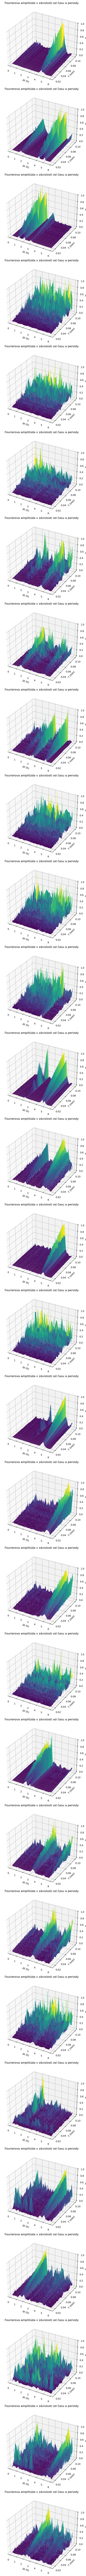

In [59]:
# vypocet frekvencii a fourierovej amplitudy pre zadane okno
def calculate_fft_in_window(signal, sampling_rate):
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(signal), d=1/sampling_rate)

    positive_freq_indices = freq > 0
    freq = freq[positive_freq_indices]
    magnitude = np.abs(fft_result)[positive_freq_indices]
    
    return freq, magnitude

# Výpočet amplitúd pre zadané časové periody
def extract_amplitudes_per_period(freq, magnitude, period_range):
    amplitudes = []
    for T in period_range:
        f = 1 / (T * 60)  # frekvencia pre periodu v sekundách
        
        closest_index = np.argmin(np.abs(freq - f))
        amplitudes.append(magnitude[closest_index])
    return amplitudes

# definovanie rozsahu period
def get_period_range(window_size, sampling_rate, num=300):
    T_min = 0.1/6 # 1 sekunda
    return np.logspace(np.log10(T_min), np.log10(0.1), num=num)

fig, ax = plt.subplots(nrows=30, ncols=1, figsize=(10, 150), subplot_kw={"projection": "3d"})

sampling_rate = 10 # vzorkovacia frekvencia
window_sizes = 6 * 3600 * sampling_rate  # 6 hodin v sekundách
step_size = sampling_rate * 60 * 10   # krok okna 10 minút v sekundách

period_ranges = [get_period_range(w, sampling_rate) for w in [window_sizes]][0]

for idx, df in amp_windows_negative[:30].iterrows():
    time_in_seconds, amplitude = (np.arange(len(df["A_base"])), np.array(df["A_base"]))
    
    time_offsets = []
    results = []
    
    start_idx = 0
    end_idx = 0
    
    while end_idx < window_sizes:
        end_idx = start_idx + step_size
        window_signal = amplitude[start_idx:end_idx]
    
        # Vypočítame FFT v okne
        freq, magnitude = calculate_fft_in_window(window_signal, sampling_rate)
    
        # # Fourierove amplitúdy pre zadané periody
        amplitudes = extract_amplitudes_per_period(freq, magnitude, period_ranges)
        results.append(amplitudes)
    
        avg_time = (time_in_seconds[start_idx] + time_in_seconds[end_idx - 1]) / 2
        time_offsets.append((avg_time / 36000))  # časový posun v hodinách
    
        start_idx += step_size
    
    results = np.array(results)
    results = results / np.max(results)
    time_offsets = np.array(time_offsets)
    
    T, Delta_t = np.meshgrid(period_ranges, time_offsets)
    
    ax[idx].plot_surface(Delta_t, T, results, cmap='viridis')
    ax[idx].set_title("Fourierova amplitúda v závislosti od času a periody")
    ax[idx].set_xlabel("\u0394t (h)")
    ax[idx].set_ylabel("T (min)")
    ax[idx].set_zlabel("A_f")

plt.tight_layout()
plt.show()

In [216]:
len(T_list[0])

36

# Priprava dat na modelovanie

In [14]:
# vypocet frekvencii a fourierovej amplitudy pre zadane okno
# pozitivne priklady

def calculate_fft_in_window(signal, sampling_rate):
    """Fourierova transformácia v danom časovom okne."""
    fft_result = np.fft.fft(signal)
    freq = np.fft.fftfreq(len(signal), d=1/sampling_rate)

    positive_freq_indices = freq > 0
    freq = freq[positive_freq_indices]
    magnitude = np.abs(fft_result)[positive_freq_indices]
    
    return freq, magnitude

# Výpočet amplitúd pre zadané časové periody
def extract_amplitudes_per_period(freq, magnitude, period_range):
    amplitudes = []
    for T in period_range:
        f = 1 / (T * 60)  # frekvencia pre periodu v sekundách !!!!!! zmena zo 60 na 1
        
        closest_index = np.argmin(np.abs(freq - f))
        amplitudes.append(magnitude[closest_index])
    return amplitudes

# definovanie rozsahu period
def get_period_range(window_sz, sampling_rate, num=300):
    T_min = 0.1/6 # 1 sekunda
    return np.logspace(np.log10(T_min), np.log10(0.1), num=num)


sampling_rate = 10 # vzorkovacia frekvencia
window_size = 6 * 3600 * sampling_rate  # 6 hodin v sekundách
step_size = sampling_rate * 60 * 10   # krok okna 10 minút v sekundách

period_ranges = [get_period_range(w, sampling_rate) for w in [window_size]][0]

results_amp_pos = []
T_list_pos = []
Delta_t_list_pos = []

for amp in list(amp_windows_positive["A_base"]):
    amplitude = np.array(amp)
    time_in_seconds = np.arange(len(amplitude))
    
    time_offsets = []
    results_amp = []
    
    start_idx = 0
    end_idx = 0
    
    while end_idx < window_size:
        end_idx = start_idx + step_size
        window_signal = amplitude[start_idx:end_idx]
    
        # Vypočítame FFT v okne
        freq, magnitude = calculate_fft_in_window(window_signal, sampling_rate)
    
        # Fourierove amplitúdy pre zadané periody
        amplitudes = extract_amplitudes_per_period(freq, magnitude, period_ranges)
        results_amp.append(amplitudes)

        avg_time = (time_in_seconds[start_idx] + time_in_seconds[end_idx - 1]) / 2
        time_offsets.append((avg_time / 36000) - 3)  # časový posun v hodinách
    
        start_idx += step_size

    results_amp = np.array(results_amp)
    results_amp = results_amp / np.max(results_amp)
    time_offsets = np.array(time_offsets)
    
    T, Delta_t = np.meshgrid(period_ranges, time_offsets)
    T = T / np.max(T)

    results_amp_pos.append(results_amp)
    T_list_pos.append(T)
    Delta_t_list_pos.append(Delta_t)

In [15]:
len(Delta_t_list_pos[0][0])

300

In [16]:
# negativne priklady
results_amp_neg = []
T_list_neg = []
Delta_t_list_neg = []

for amp in list(amp_windows_negative["A_base"]):
    amplitude = np.array(amp)
    time_in_seconds = np.arange(len(amplitude))
    
    time_offsets = []
    results_amp = []
    
    start_idx = 0
    end_idx = 0
    
    while end_idx < window_size:
        end_idx = start_idx + step_size
        window_signal = amplitude[start_idx:end_idx]
    
        # Vypočítame FFT v okne
        freq, magnitude = calculate_fft_in_window(window_signal, sampling_rate)
    
        # Fourierove amplitúdy pre zadané periody
        amplitudes = extract_amplitudes_per_period(freq, magnitude, period_ranges)
        results_amp.append(amplitudes)

        avg_time = (time_in_seconds[start_idx] + time_in_seconds[end_idx - 1]) / 2
        time_offsets.append((avg_time / 36000))  # časový posun v hodinách
    
        start_idx += step_size

    results_amp = np.array(results_amp)
    results_amp = results_amp / np.max(results_amp)
    time_offsets = np.array(time_offsets)
    
    T, Delta_t = np.meshgrid(period_ranges, time_offsets)
    T = T / np.max(T)

    results_amp_neg.append(results_amp)
    T_list_neg.append(T)
    Delta_t_list_neg.append(Delta_t)

In [17]:
len(results_amp_neg[0][0])

300

In [18]:
# vytvorenie dataframov s pozitivnymi a negativnymi prikladmi
amp_windows_positive_fourier = pd.DataFrame(
    {
        "A_base_fourier": results_amp_pos,
        "T": T_list_pos,
        "Delta_t": Delta_t_list_pos,
        "is_eq": 1
    }
)

amp_windows_negative_fourier = pd.DataFrame(
    {
        "A_base_fourier": results_amp_neg,
        "T": T_list_neg,
        "Delta_t": Delta_t_list_neg,
        "is_eq": 0
    }
)

# Modelovnaie

In [72]:
# rozdelenie dat na modelovanie
amp_windows_positive_sample = amp_windows_positive_fourier.sample(351)
amp_windows_negative_sample = amp_windows_negative_fourier.sample(351)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array([
    np.concatenate([
        seq.reshape(-1, 1)
        for seq in row
    ])
    for row in data[["A_base_fourier", "T"]].values
])

Epoch 1/40


/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5450 - loss: 3.9881 - val_accuracy: 0.4588 - val_loss: 0.6932
Epoch 2/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4892 - loss: 0.8183 - val_accuracy: 0.5412 - val_loss: 0.6931
Epoch 3/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5283 - loss: 0.7044 - val_accuracy: 0.5412 - val_loss: 0.6931
Epoch 4/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5677 - loss: 0.6843 - val_accuracy: 0.5412 - val_loss: 0.6931
Epoch 5/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5782 - loss: 0.6725 - val_accuracy: 0.5412 - val_loss: 0.6931
Epoch 6/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6182 - loss: 0.6754 - val_accuracy: 0.5647 - val_loss: 0.6931
Epoch 7/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.5967 - loss: 0.6648 - val_accuracy: 0.5529 - val_loss: 0.6930
Epoch 8/40
15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.6146 - loss: 0.6462 - val_accuracy: 0.5412 - val_loss: 0.6930
Epo

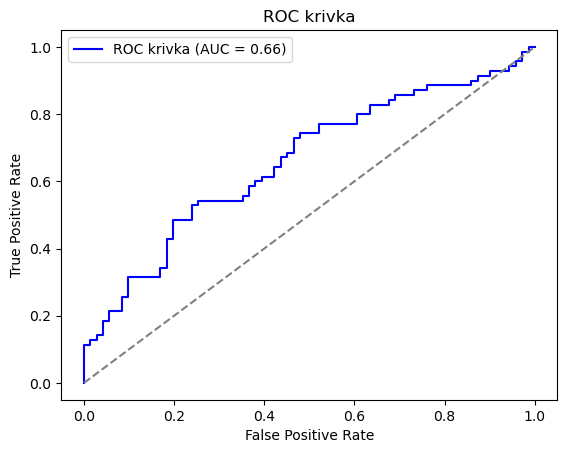

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.62      0.62        71
           1       0.61      0.60      0.60        70

    accuracy                           0.61       141
   macro avg       0.61      0.61      0.61       141
weighted avg       0.61      0.61      0.61       141



In [75]:
# modelovnaie
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Conv1D(128, kernel_size=3, activation='relu', input_shape=(X.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    Flatten(),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X_train, 
    y_train, 
    epochs=40, 
    batch_size=32, 
    validation_split=0.15,
    callbacks=[early_stopping]
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Testovacia presnosť: {test_acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# ROC krivka
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC krivka (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC krivka")
plt.legend()
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

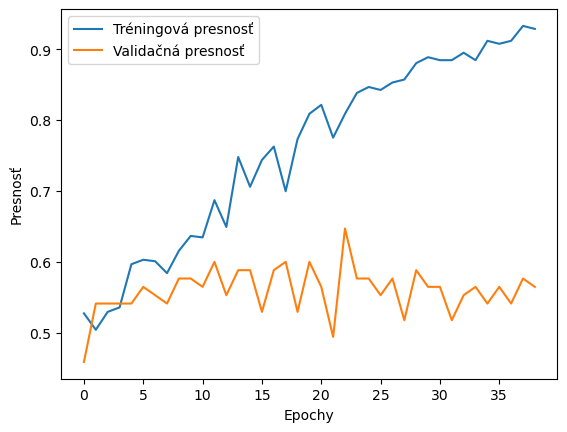

In [76]:
# priebeh ucenia sa modelu v priebehu epoch
plt.plot(history.history['accuracy'], label='Tréningová presnosť')
plt.plot(history.history['val_accuracy'], label='Validačná presnosť')
plt.xlabel('Epochy')
plt.ylabel('Presnosť')
plt.legend()
plt.show()

In [28]:
# zlozenie modelu
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 21598, 128)     │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 21598, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10799, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10799, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10797, 64)      │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5398, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5398, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5396, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2698, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 2698, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86336)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │        86,337 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,021 (1.35 MB)

 Trainable params: 117,921 (460.63 KB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 235,844 (921.27 KB)

## MLP

In [19]:
# rozdelenie dat na modelovanie
amp_windows_positive_sample = amp_windows_positive_fourier.sample(351)
amp_windows_negative_sample = amp_windows_negative_fourier.sample(351)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array([
    np.concatenate([
        seq.reshape(-1, 1)
        for seq in row
    ])
    for row in data[["A_base_fourier", "T"]].values
])

Epoch 1/90


/opt/conda/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5456 - loss: 0.9507 - val_accuracy: 0.5176 - val_loss: 0.8291
Epoch 2/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5871 - loss: 0.8740 - val_accuracy: 0.4824 - val_loss: 0.7993
Epoch 3/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5654 - loss: 0.8043 - val_accuracy: 0.5529 - val_loss: 0.8436
Epoch 4/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6061 - loss: 0.7911 - val_accuracy: 0.5176 - val_loss: 1.1863
Epoch 5/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6218 - loss: 0.7531 - val_accuracy: 0.5176 - val_loss: 1.3193
Epoch 6/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6597 - loss: 0.6740 - val_accuracy: 0.5059 - val_loss: 1.0535
Epoch 7/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6354 - loss: 0.6912 - val_accuracy: 0.5412 - val_loss: 0.9618
Epoch 8/90
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6771 - loss: 0.6279 - val_accuracy: 0.5059 - val_loss: 0.

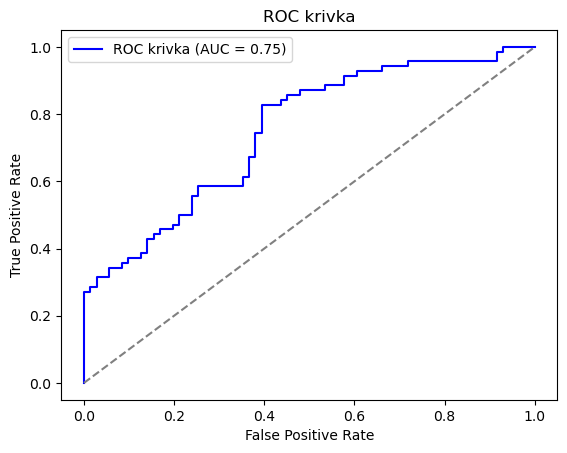

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.56      0.66        71
           1       0.66      0.84      0.74        70

    accuracy                           0.70       141
   macro avg       0.72      0.70      0.70       141
weighted avg       0.72      0.70      0.70       141



In [22]:
# modelovnaie
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = Sequential([
    Flatten(input_shape=(X.shape[1], 1)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(1, activation='sigmoid')
])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

model.compile(optimizer=keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, 
    y_train, 
    epochs=90, 
    batch_size=32, 
    validation_split=0.15,
    callbacks=[early_stopping]
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Testovacia presnosť: {test_acc:.4f}")

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# ROC krivka
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC krivka (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC krivka")
plt.legend()
plt.show()

print("Classification Report:")
print(classification_report(y_test, y_pred))

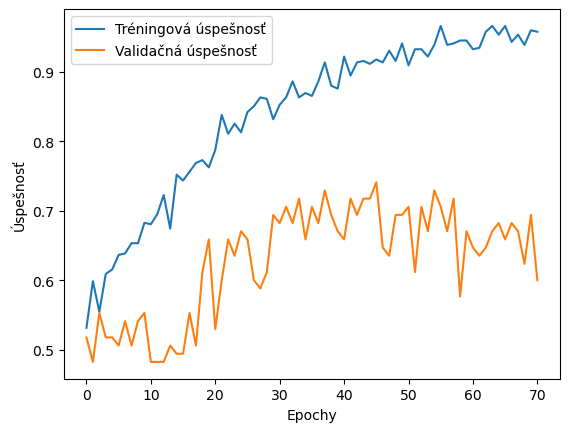

In [23]:
# priebeh ucenia sa modelu v priebehu epoch
plt.plot(history.history['accuracy'], label='Tréningová úspešnosť')
plt.plot(history.history['val_accuracy'], label='Validačná úspešnosť')
plt.xlabel('Epochy')
plt.ylabel('Úspešnosť')
plt.legend()
plt.show()

In [24]:
# zlozenie modelu
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 21600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     2,764,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,327,685 (31.77 MB)

 Trainable params: 2,775,745 (10.59 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 5,551,492 (21.18 MB)

# SVC

In [65]:
# rozdelenie dat na trenovaciu a testovaciu mnozinu
amp_windows_positive_sample = amp_windows_positive_fourier.sample(351)
amp_windows_negative_sample = amp_windows_negative_fourier.sample(351)
data = pd.concat([amp_windows_positive_sample, amp_windows_negative_sample], ignore_index=True)
data = shuffle(data)

y = data["is_eq"]
X = np.array([
    np.concatenate([
        seq.reshape(-1, 1)
        for seq in row
    ])
    for row in data[["A_base_fourier", "T"]].values
])

nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [66]:
# modelovnaie
train_scores = []
test_scores = []
y_pred_list = []
reg_c = np.arange(0.1, 3, 0.2)

for c in reg_c:
    model = LinearSVC(C=c, penalty='l1')
    model.fit(X_train, y_train)

    # uspesnost na tréningovej a testovacej množine
    train_acc = accuracy_score(y_train, model.predict(X_train))

    y_pred = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)

    train_scores.append(train_acc)
    test_scores.append(test_acc)
    y_pred_list.append(y_pred)

/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

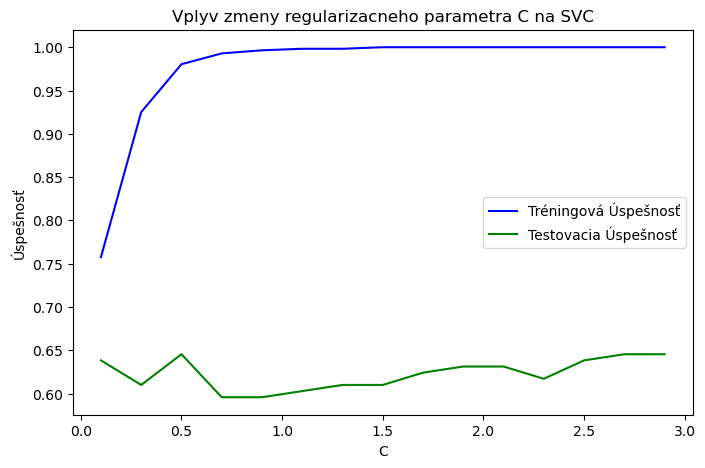

Classification Report #0:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65        74
           1       0.61      0.64      0.63        67

    accuracy                           0.64       141
   macro avg       0.64      0.64      0.64       141
weighted avg       0.64      0.64      0.64       141

Classification Report #1:
              precision    recall  f1-score   support

           0       0.63      0.64      0.63        74
           1       0.59      0.58      0.59        67

    accuracy                           0.61       141
   macro avg       0.61      0.61      0.61       141
weighted avg       0.61      0.61      0.61       141

Classification Report #2:
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        74
           1       0.63      0.60      0.62        67

    accuracy                           0.65       141
   macro avg       0.64      0.64      0.64       

In [67]:
# priebeh ucenia na zaklade zvoleneho hyperparametra
plt.figure(figsize=(8, 5))
plt.plot(reg_c, train_scores, label="Tréningová Úspešnosť", color="blue")
plt.plot(reg_c, test_scores, label="Testovacia Úspešnosť", color="green")
plt.xlabel("C")
plt.ylabel("Úspešnosť")
plt.title("Vplyv zmeny regularizacneho parametra C na SVC")
plt.legend()
plt.show()

for i, pred in enumerate(y_pred_list):
    print(f"Classification Report #{i}:")
    print(classification_report(y_test, pred))

In [68]:
# vyber najlepsej hodnoty hyperparametra a trening modelu s touto hodnotou
model = LinearSVC(C=0.4, penalty='l1')
model.fit(X_train, y_train)

# uspesnost na tréningovej a testovacej množine
train_acc = accuracy_score(y_train, model.predict(X_train))

y_pred = model.predict(X_test)
test_acc = accuracy_score(y_test, y_pred)

train_scores.append(train_acc)
test_scores.append(test_acc)
y_pred_list.append(y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65        74
           1       0.62      0.60      0.61        67

    accuracy                           0.63       141
   macro avg       0.63      0.63      0.63       141
weighted avg       0.63      0.63      0.63       141



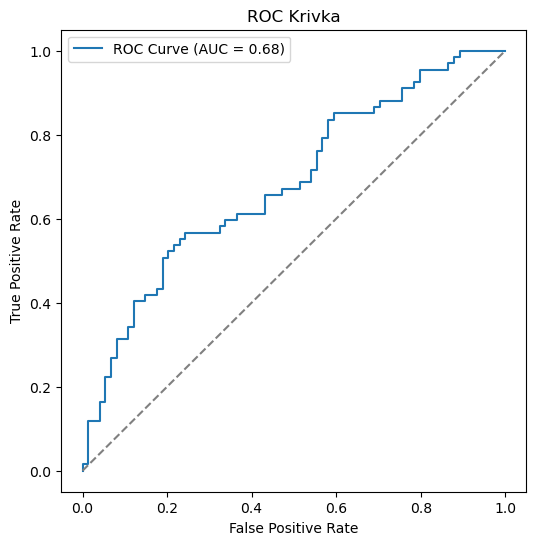

In [69]:
# ROC krivka
y_probs = model.decision_function(X_test)
roc_auc = roc_auc_score(y_test, y_probs)
fpr, tpr, _ = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Krivka')
plt.legend()
plt.show()